<a href="https://colab.research.google.com/github/davideneffat/movie_recommendations/blob/main/movielens.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
from torch import Tensor
print(torch.__version__)

2.1.0+cu121


In [2]:
# Install required packages.
import os
os.environ['TORCH'] = torch.__version__

!pip install torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install pyg-lib -f https://data.pyg.org/whl/nightly/torch-${TORCH}.html
!pip install git+https://github.com/pyg-team/pytorch_geometric.git

Looking in links: https://data.pyg.org/whl/torch-2.1.0+cu121.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 12.9 MB/s eta 0:00:00
Looking in links: https://data.pyg.org/whl/torch-2.1.0+cu121.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 29.2 MB/s eta 0:00:00
Looking in links: https://data.pyg.org/whl/nightly/torch-2.1.0+cu121.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 4.9 MB/s eta 0:00:00
  Cloning https://github.com/pyg-team/pytorch_geometric.git to /tmp/pip-req-build-ie2yxfkx
  Running command git clone --filter=blob:none --quiet https://github.com/pyg-team/pytorch_geometric.git /tmp/pip-req-build-ie2yxfkx
  Resolved https://github.com/pyg-team/pytorch_geometric.git to commit 570f08e54149e3a4dc1d1e6c62c6c95b32c66ce7
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for torch_geometric: filename=torch_geometric-2.4.0-py3-none-any.whl 

In [3]:
from torch_geometric.data import download_url, extract_zip

url = 'https://files.grouplens.org/datasets/movielens/ml-latest-small.zip'
extract_zip(download_url(url, '.'), '.')

movies_path = './ml-latest-small/movies.csv'
ratings_path = './ml-latest-small/ratings.csv'

Extracting ./ml-latest-small.zip


In [4]:
import pandas as pd

print('movies.csv:')
pd.read_csv(movies_path).head()

movies.csv:


,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [5]:
movies_df = pd.read_csv(movies_path, index_col='movieId')

# Split genres and convert into indicator variables:
genres = movies_df['genres'].str.get_dummies('|')#creates a binary indicator for each genre, separated by the '|' delimiter
print(genres[["Action", "Adventure", "Drama", "Horror","Animation","Fantasy"]].head())

# Use genres as movie input features:
movie_feat = torch.from_numpy(genres.values).to(torch.float)#tensor of movie features, size (9742, 20) = (# nodes, # genres)

         Action  Adventure  Drama  Horror  Animation  Fantasy
movieId                                                      
1             0          1      0       0          1        1
2             0          1      0       0          0        1
3             0          0      0       0          0        0
4             0          0      1       0          0        0
5             0          0      0       0          0        0


In [6]:
movies_df.head()

,title,genres
movieId,,
1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
2,Jumanji (1995),Adventure|Children|Fantasy
3,Grumpier Old Men (1995),Comedy|Romance
4,Waiting to Exhale (1995),Comedy|Drama|Romance
5,Father of the Bride Part II (1995),Comedy


In [7]:
ratings_df = pd.read_csv(ratings_path)

In [8]:
print('ratings.csv:')
ratings_df.head()

ratings.csv:


,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


<ipython-input-9-ad68d10fd129>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['{:,.0%}'.format(x) for x in vals])


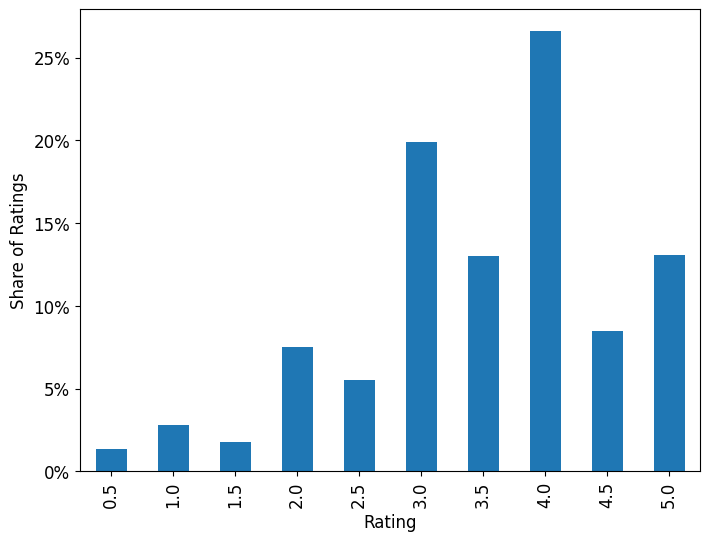

In [9]:
#print ratings distribution
from matplotlib import pyplot as plt

fig = plt.figure()
ax = ratings_df.rating.value_counts(True).sort_index().plot.bar(figsize=(8,6))
vals = ax.get_yticks()
ax.set_yticklabels(['{:,.0%}'.format(x) for x in vals])
plt.xlabel('Rating', fontsize=12)
plt.ylabel('Share of Ratings', fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
fig.savefig('Ratings_distribution.png')

In [10]:
#let's round ratings to integers for simplicity
import numpy as np

ratings_df['rating'] = np.ceil(ratings_df['rating']).astype(int)

<ipython-input-11-d6e9c3372f83>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['{:,.0%}'.format(x) for x in vals])


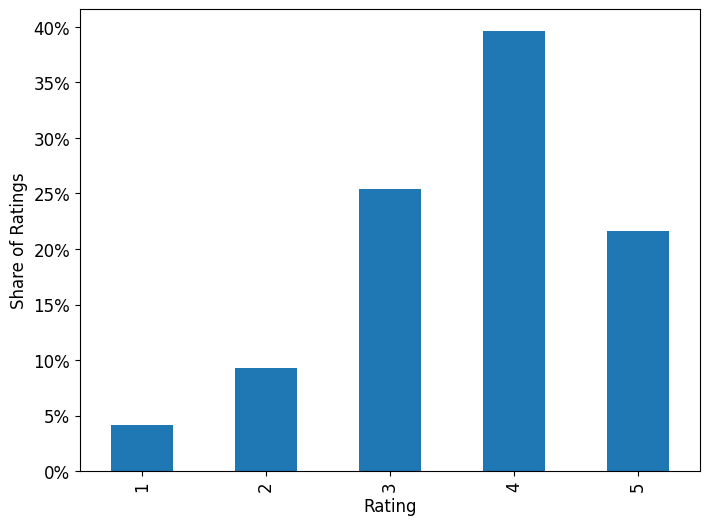

In [11]:
#print new ratings distribution
from matplotlib import pyplot as plt

fig = plt.figure()
ax = ratings_df.rating.value_counts(True).sort_index().plot.bar(figsize=(8,6))
vals = ax.get_yticks()
ax.set_yticklabels(['{:,.0%}'.format(x) for x in vals])
plt.xlabel('Rating', fontsize=12)
plt.ylabel('Share of Ratings', fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
fig.savefig('Ratings_distribution.png')

In [12]:
#to take into account review rating: duplicate each row (so each edge) for a value equal to the rating
ratings_df = ratings_df.loc[ratings_df.index.repeat(ratings_df['rating'])].reset_index(drop=True)
ratings_df.head(15)

,userId,movieId,rating,timestamp
0,1,1,4,964982703
1,1,1,4,964982703
2,1,1,4,964982703
3,1,1,4,964982703
4,1,3,4,964981247
5,1,3,4,964981247
6,1,3,4,964981247
7,1,3,4,964981247
8,1,6,4,964982224
9,1,6,4,964982224


In [13]:
# Create a mapping from unique user indices to range [0, num_user_nodes):
unique_user_id = ratings_df['userId'].unique()
unique_user_id = pd.DataFrame(data={
    'userId': unique_user_id,
    'mappedID': pd.RangeIndex(len(unique_user_id)),#because userId are not consecutive values, there are jumps. Same for movies
})
print("Mapping of user IDs to consecutive values:")
print(unique_user_id.head())
print(unique_user_id.tail())
print()
# Create a mapping from unique movie indices to range [0, num_movie_nodes):
unique_movie_id = ratings_df['movieId'].unique()
unique_movie_id = pd.DataFrame(data={
    'movieId': movies_df.index,
    'mappedID': pd.RangeIndex(len(movies_df)),
})
print("Mapping of movie IDs to consecutive values:")
print(unique_movie_id.head())
print(unique_movie_id.tail())

# Perform merge to obtain the edges from users and movies:
ratings_user_id = pd.merge(ratings_df['userId'], unique_user_id, left_on='userId', right_on='userId', how='left')
ratings_user_id = torch.from_numpy(ratings_user_id['mappedID'].values)#create tensor of user ids
ratings_movie_id = pd.merge(ratings_df['movieId'], unique_movie_id, left_on='movieId', right_on='movieId', how='left')
ratings_movie_id = torch.from_numpy(ratings_movie_id['mappedID'].values)#create tensor of movies ids

#create tensor of edges (userId -> movieId)
edge_index_user_to_movie = torch.stack([ratings_user_id, ratings_movie_id], dim=0)#joint the 2 id tensors into a single tensor of size (2, #edges)

print()
print("Final edge indices pointing from users to movies:")
print(edge_index_user_to_movie)

Mapping of user IDs to consecutive values:
   userId  mappedID
0       1         0
1       2         1
2       3         2
3       4         3
4       5         4
     userId  mappedID
605     606       605
606     607       606
607     608       607
608     609       608
609     610       609

Mapping of movie IDs to consecutive values:
   movieId  mappedID
0        1         0
1        2         1
2        3         2
3        4         3
4        5         4
      movieId  mappedID
9737   193581      9737
9738   193583      9738
9739   193585      9739
9740   193587      9740
9741   193609      9741

Final edge indices pointing from users to movies:
tensor([[   0,    0,    0,  ...,  609,  609,  609],
        [   0,    0,    0,  ..., 9503, 9503, 9503]])


In [14]:
#define functions to get original movie id from the mapped one and viceversa
def get_original_node(index):
  row = unique_movie_id[unique_movie_id['mappedID'] == index]
  return row['movieId'].values[0]

def get_mapped_node(index):
  row = unique_movie_id[unique_movie_id['movieId'] == index]
  return row['mappedID'].values[0]

print(get_original_node(6405))
print(get_mapped_node(1258))

50872
957


In [15]:
#let's create the graph
from torch_geometric.data import HeteroData
import torch_geometric.transforms as T

data = HeteroData()

# Save node indices:
data["user"].node_id = torch.arange(len(unique_user_id))
data["movie"].node_id = torch.arange(len(movies_df))

# Add the node features and edge indices:
data["movie"].x = movie_feat
data["user", "rates", "movie"].edge_index = edge_index_user_to_movie  #edge_index = tensor (2,#edges) with for each edge (mapped) user id and (mapped) movie id

# We also need to make sure to add the reverse edges from movies to users
# in order to let a GNN be able to pass messages in both directions.
# We can leverage the `T.ToUndirected()` transform for this from PyG:
data = T.ToUndirected()(data)

print(data)


HeteroData(
  user={ node_id=[610] },
  movie={
    node_id=[9742],
    x=[9742, 20],
  },
  (user, rates, movie)={ edge_index=[2, 368282] },
  (movie, rev_rates, user)={ edge_index=[2, 368282] }
)


In [16]:
# training (80%), validation (10%), and testing edges (10%).
# Across the training edges, we use 70% of edges for message passing, and 30% of edges for supervision.
transform = T.RandomLinkSplit(
    num_val=0.1,#10% validation set
    num_test=0.1,#10% test set
    disjoint_train_ratio=0.3,#30% disjoint training set
    neg_sampling_ratio=2.0,#negative samples are double of positive samples
    add_negative_train_samples=False,
    edge_types=("user", "rates", "movie"),
    rev_edge_types=("movie", "rev_rates", "user"),
)

# edge_index (edges used for message passing) + edge_label_index (edges used for supervision) = training_set = 80%

train_data, val_data, test_data = transform(data)
print("Training data:")
print("--------------")
print(train_data)
print()
print("User IDs:")
print(train_data["user", "rates", "movie"].edge_index[0][:10])
print("Movie IDs:")
print(train_data["user", "rates", "movie"].edge_index[1][:10])
print("Edges labels:")
print(train_data["user", "rates", "movie"].edge_label[:10])
print(train_data["user", "rates", "movie"].edge_label[-10:]) #only positive labels (1)
print("Edges labels indices:")
print(train_data["user", "rates", "movie"].edge_label_index[0][:10])
print(train_data["user", "rates", "movie"].edge_label_index[1][:10])

print()
print("Validation data:")
print("-----------------")
print(val_data)
print()
print("Test data:")
print("-----------")
print(test_data)

Training data:
--------------
HeteroData(
  user={ node_id=[610] },
  movie={
    node_id=[9742],
    x=[9742, 20],
  },
  (user, rates, movie)={
    edge_index=[2, 206239],
    edge_label=[88387],
    edge_label_index=[2, 88387],
  },
  (movie, rev_rates, user)={ edge_index=[2, 206239] }
)

User IDs:
tensor([413, 418, 496, 605,  46, 602, 273, 487, 447,  44])
Movie IDs:
tensor([4100,  613, 2078,  723, 9438, 2011, 4422, 3622, 4581, 1117])
Edges labels:
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
Edges labels indices:
tensor([361, 453, 595, 541, 102, 390,  22, 598, 609, 586])
tensor([5917, 1449, 8572, 4615, 7697, 1725, 1336, 3003, 6428,  508])

Validation data:
-----------------
HeteroData(
  user={ node_id=[610] },
  movie={
    node_id=[9742],
    x=[9742, 20],
  },
  (user, rates, movie)={
    edge_index=[2, 294626],
    edge_label=[110484],
    edge_label_index=[2, 110484],
  },
  (movie, rev_rates, user)={ edge_index=[2, 294626] 

In [17]:
#creation of mini batches
from torch_geometric.loader import LinkNeighborLoader

#The data loader will add the following attributes to the returned mini-batch:
#-n_id The global node index for every sampled node
#-e_id The global edge index for every sampled edge
#-input_id: The global index of the edge_label_index
#-num_sampled_nodes: The number of sampled nodes in each hop
#-num_sampled_edges: The number of sampled edges in each hop

# Define seed edges:
edge_label_index = train_data["user", "rates", "movie"].edge_label_index  #Size([2, 24201])
edge_label = train_data["user", "rates", "movie"].edge_label  #Size([24201])

train_loader = LinkNeighborLoader(
    data=train_data,
    num_neighbors=[20, 10],#The number of neighbors to sample for each node in each iteration (20 the first, 10 the second)
    neg_sampling_ratio=2.0,
    edge_label_index=(("user", "rates", "movie"), edge_label_index),
    edge_label=edge_label,#The labels of edge indices for which neighbors are sampled
    batch_size=128,
    shuffle=True,
)

# Inspect a sample:
sampled_data = next(iter(train_loader))

print("Sampled mini-batch:")
print("===================")
print(sampled_data)

assert sampled_data["user", "rates", "movie"].edge_label_index.size(1) == 3 * 128
assert sampled_data["user", "rates", "movie"].edge_label.min() == 0
assert sampled_data["user", "rates", "movie"].edge_label.max() == 1

Sampled mini-batch:
HeteroData(
  user={
    node_id=[607],
    n_id=[607],
    num_sampled_nodes=[3],
  },
  movie={
    node_id=[2680],
    x=[2680, 20],
    n_id=[2680],
    num_sampled_nodes=[3],
  },
  (user, rates, movie)={
    edge_index=[2, 21413],
    edge_label=[384],
    edge_label_index=[2, 384],
    e_id=[21413],
    num_sampled_edges=[2],
    input_id=[128],
  },
  (movie, rev_rates, user)={
    edge_index=[2, 8200],
    e_id=[8200],
    num_sampled_edges=[2],
  }
)


In [18]:
from torch_geometric.nn import SAGEConv, to_hetero
import torch.nn.functional as F

class GNN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()

        self.conv1 = SAGEConv(hidden_channels, hidden_channels)
        self.conv2 = SAGEConv(hidden_channels, hidden_channels)

    def forward(self, x: Tensor, edge_index: Tensor) -> Tensor:
        x = F.relu(self.conv1(x, edge_index))
        x = self.conv2(x, edge_index)
        return x

# Our final classifier applies the dot-product between source and destination
# node embeddings to derive edge-level predictions: (Combines user and movie node embeddings to create edge-level representations)
class Classifier(torch.nn.Module):
    def forward(self, x_user: Tensor, x_movie: Tensor, edge_label_index: Tensor) -> Tensor:
        # Convert node embeddings to edge-level representations:
        edge_feat_user = x_user[edge_label_index[0]]
        edge_feat_movie = x_movie[edge_label_index[1]]

        # Apply dot-product to get a prediction per supervision edge:
        return (edge_feat_user * edge_feat_movie).sum(dim=-1)


class Model(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        # Since the dataset does not come with rich features, we also learn two
        # embedding matrices for users and movies:
        self.movie_lin = torch.nn.Linear(20, hidden_channels)  #(movie_lin): Linear(in_features=20, out_features=64, bias=True)
        self.user_emb = torch.nn.Embedding(data["user"].num_nodes, hidden_channels)#learn node embedding for users
        self.movie_emb = torch.nn.Embedding(data["movie"].num_nodes, hidden_channels)#learn node embedding for movies

        # Instantiate homogeneous GNN:
        self.gnn = GNN(hidden_channels)

        # Convert GNN model into a heterogeneous variant (we have user and movie types nodes):
        self.gnn = to_hetero(self.gnn, metadata=data.metadata())

        self.classifier = Classifier()

    def forward(self, data: HeteroData) -> Tensor:
        x_dict = {
          "user": self.user_emb(data["user"].node_id),#just learned embeddings
          "movie": self.movie_lin(data["movie"].x) + self.movie_emb(data["movie"].node_id),#movie genres + learned embeddings
        }

        # `x_dict` holds feature matrices of all node types
        # `edge_index_dict` holds all edge indices of all edge types
        x_dict = self.gnn(x_dict, data.edge_index_dict)
        pred = self.classifier(
            x_dict["user"],
            x_dict["movie"],
            data["user", "rates", "movie"].edge_label_index,
        )

        return pred


model = Model(hidden_channels=64)

print(model)

Model(
  (movie_lin): Linear(in_features=20, out_features=64, bias=True)
  (user_emb): Embedding(610, 64)
  (movie_emb): Embedding(9742, 64)
  (gnn): GraphModule(
    (conv1): ModuleDict(
      (user__rates__movie): SAGEConv(64, 64, aggr=mean)
      (movie__rev_rates__user): SAGEConv(64, 64, aggr=mean)
    )
    (conv2): ModuleDict(
      (user__rates__movie): SAGEConv(64, 64, aggr=mean)
      (movie__rev_rates__user): SAGEConv(64, 64, aggr=mean)
    )
  )
  (classifier): Classifier()
)


/usr/local/lib/python3.10/dist-packages/torch/overrides.py:110: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  torch.has_cuda,
/usr/local/lib/python3.10/dist-packages/torch/overrides.py:111: UserWarning: 'has_cudnn' is deprecated, please use 'torch.backends.cudnn.is_available()'
  torch.has_cudnn,
/usr/local/lib/python3.10/dist-packages/torch/overrides.py:117: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  torch.has_mps,
/usr/local/lib/python3.10/dist-packages/torch/overrides.py:118: UserWarning: 'has_mkldnn' is deprecated, please use 'torch.backends.mkldnn.is_available()'
  torch.has_mkldnn,


In [19]:
#train model
import tqdm
import torch.nn.functional as F

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: '{device}'")

model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

for epoch in range(1, 11):#reduce to 6 for 10/20m dataset
    total_loss = total_examples = 0
    for sampled_data in tqdm.tqdm(train_loader):#iterating over mini-batches
        optimizer.zero_grad()

        sampled_data.to(device)
        pred = model(sampled_data)

        ground_truth = sampled_data["user", "rates", "movie"].edge_label
        loss = F.binary_cross_entropy_with_logits(pred, ground_truth)

        loss.backward()
        optimizer.step()
        total_loss += float(loss) * pred.numel()
        total_examples += pred.numel()
    print(f"Epoch: {epoch:03d}, Loss: {total_loss / total_examples:.4f}")

Device: 'cpu'


100%|██████████| 691/691 [00:52<00:00, 13.08it/s]


Epoch: 001, Loss: 0.3319


100%|██████████| 691/691 [00:38<00:00, 17.77it/s]


Epoch: 002, Loss: 0.2509


100%|██████████| 691/691 [00:40<00:00, 17.11it/s]


Epoch: 003, Loss: 0.2304


100%|██████████| 691/691 [00:38<00:00, 17.88it/s]


Epoch: 004, Loss: 0.2173


100%|██████████| 691/691 [00:39<00:00, 17.63it/s]


Epoch: 005, Loss: 0.2083


100%|██████████| 691/691 [00:39<00:00, 17.71it/s]


Epoch: 006, Loss: 0.2019


100%|██████████| 691/691 [00:37<00:00, 18.65it/s]


Epoch: 007, Loss: 0.1965


100%|██████████| 691/691 [00:38<00:00, 18.00it/s]


Epoch: 008, Loss: 0.1933


100%|██████████| 691/691 [00:39<00:00, 17.51it/s]


Epoch: 009, Loss: 0.1855


100%|██████████| 691/691 [00:39<00:00, 17.68it/s]

Epoch: 010, Loss: 0.1845


In [20]:
# Define the validation seed edges:
edge_label_index = val_data["user", "rates", "movie"].edge_label_index
edge_label = val_data["user", "rates", "movie"].edge_label

val_loader = LinkNeighborLoader(#creates mini-batches for validation set
    data=val_data,
    num_neighbors=[20, 10],
    edge_label_index=(("user", "rates", "movie"), edge_label_index),
    edge_label=edge_label,
    batch_size=3 * 128,
    shuffle=False,
)

sampled_data = next(iter(val_loader))

print("Sampled mini-batch:")
print("===================")
print(sampled_data)

Sampled mini-batch:
HeteroData(
  user={
    node_id=[608],
    n_id=[608],
    num_sampled_nodes=[3],
  },
  movie={
    node_id=[2565],
    x=[2565, 20],
    n_id=[2565],
    num_sampled_nodes=[3],
  },
  (user, rates, movie)={
    edge_index=[2, 22334],
    edge_label=[384],
    edge_label_index=[2, 384],
    e_id=[22334],
    num_sampled_edges=[2],
    input_id=[384],
  },
  (movie, rev_rates, user)={
    edge_index=[2, 7830],
    e_id=[7830],
    num_sampled_edges=[2],
  }
)


In [21]:
from sklearn.metrics import roc_auc_score

preds = []
ground_truths = []
for sampled_data in tqdm.tqdm(val_loader):
    with torch.no_grad():
        sampled_data.to(device)
        preds.append(model(sampled_data))
        ground_truths.append(sampled_data["user", "rates", "movie"].edge_label)

pred = torch.cat(preds, dim=0).cpu().numpy()
ground_truth = torch.cat(ground_truths, dim=0).cpu().numpy()
auc = roc_auc_score(ground_truth, pred)
print()
print(f"Validation AUC: {auc:.4f}")
print()
print("Predictions for existing edges:")
print(pred[:30])
print(ground_truth[:30])
print("Predictions for non-existing edges:")
print(pred[-30:])
print(ground_truth[-30:])

100%|██████████| 288/288 [00:06<00:00, 41.51it/s]



Validation AUC: 0.9759

Predictions for existing edges:
[ 3.5265791   1.8312278   1.7304323   1.2635907   1.2211999   1.9546263
  1.0594518   2.6331754   1.4776399   3.2984245  -1.327633    2.499155
 -1.9752803   4.5249357   0.258048    4.0974526   0.53432465  1.0741845
  3.9600196   3.9828942   2.7017026   2.7573035   0.6632174   0.42196754
  0.20086601  2.8682654   3.0274725   0.62490416  1.2176926  -2.3346353 ]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1.]
Predictions for non-existing edges:
[-5.5220079e+00 -5.3888454e+00 -6.3448205e+00 -8.8827014e-03
 -1.1356523e+01 -5.3631320e+00 -1.3318587e+01  1.6195329e+00
 -1.2783760e+01 -4.1019678e+00 -1.5136701e+00 -7.0213041e+00
  1.9368339e+00 -3.5536418e+00 -1.4718741e+01 -5.0936794e+00
 -9.7595945e-02 -7.0224204e+00 -5.4164071e+00  3.6300967e+00
 -9.5033979e+00 -4.0593071e+00 -2.3744917e+00 -1.1020037e+00
 -9.7014484e+00 -1.4445389e+01 -9.4504356e+00 -8.9909506e+00
 -2.5332010e+01 -3.686044

In [117]:
#test our model prediction for a specific user:
user_index = 599  #value from 1 to 610 for the 100k nodes dataset

In [118]:
user_index = user_index - 1  #due to the mapping (mapped used ids start from 0)
user_ids = torch.full((data["movie"].num_nodes,), user_index)
movie_ids = torch.tensor(unique_movie_id['mappedID'])
edge_label_index = torch.stack([user_ids, movie_ids], dim=0)#joint the 2 id tensors into a single tensor of size (2, #edges)

print(edge_label_index)  #tensor with all possible movies that our user can see

val_loader = LinkNeighborLoader(#creates mini-batches for validation set
    data=data,
    num_neighbors=[20, 10],
    edge_label_index=(("user", "rates", "movie"), edge_label_index),
    batch_size=3 * 128,
    shuffle=False,
)

preds = []
for sampled_data in tqdm.tqdm(val_loader):
    with torch.no_grad():
        sampled_data.to(device)
        preds.append(model(sampled_data))

pred = torch.cat(preds, dim=0).cpu().numpy()

print()

tensor([[ 598,  598,  598,  ...,  598,  598,  598],
        [   0,    1,    2,  ..., 9739, 9740, 9741]])


100%|██████████| 26/26 [00:00<00:00, 89.48it/s]

In [119]:
def get_max(): #function that extract max probability from probabilities array
  max = pred[0]
  #maxIndex = 0
  for i in range(len(pred)):
      if pred[i] > max:
          max = pred[i]
          maxIndex = i
  print(get_original_node(maxIndex))#already seen movies, the last is the not-seen one
  return maxIndex

In [120]:
user_index = user_index + 1  #reverse mapping

In [121]:
#let's find the first most similar movie not already seen
most_similar_movie = get_max()
row = ratings_df[(ratings_df['userId'] == user_index) & (ratings_df['movieId'] == get_original_node(most_similar_movie))]
while not row.empty: #repeat untill find a not-seen movie
  pred[most_similar_movie] = -100
  most_similar_movie = get_max()
  row = ratings_df[(ratings_df['userId'] == user_index) & (ratings_df['movieId'] == get_original_node(most_similar_movie))]
print("Most similar not-seen movie for user {} is {}".format(user_index, get_original_node(most_similar_movie)))

94122
98697
92674
8905
7707
89862
4597
95499
42638
4568
5768
8755
5591
128736
120827
95771
8045
2281
5268
1114
95839
7988
3700
8506
95965
7986
5198
42943
806
3962
95780
8934
2698
116169
90428
163809
4125
116044
95165
8043
138702
98799
5961
128197
129779
181315
145745
3709
7125
91981
40578
3906
112326
4394
60365
93502
140852
4490
62662
5423
7005
8720
115819
119218
8380
137859
144522
54274
77201
61073
132084
114126
4511
5054
122433
3830
4603
139859
55207
91571
161008
7041
59336
4504
97230
3454
170297
4470
179053
8500
143245
136012
119828
4197
79895
78959
32515
34811
93208
86355
7354
5556
5988
5688
3669
139130
57499
4240
47721
44238
42559
122260
1382
31921
4617
113849
27306
151479
5696
172253
121035
82534
98503
74696
6882
75947
2292
88593
72479
84523
55061
4670
136449
7782
59947
86286
4594
5596
7845
26741
90243
5521
96004
55036
5841
122627
95147
123310
131578
376
6966
172233
45382
60803
54908
43677
2339
33966
47793
43908
5053
159061
95182
172229
3947
183301
33629
3688
26913
8425
26622
274

In [122]:
#let's show the movies that our user has seen
print("Movies already seen by user {}:".format(user_index))
result_df = ratings_df[ratings_df['userId'] == user_index].merge(movies_df, on='movieId', how='inner')
unique_movies = result_df.drop_duplicates(subset=['movieId'])
unique_movies[['rating','title','genres']]

Movies already seen by user 599:


,rating,title,genres
0,3,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
3,3,Jumanji (1995),Adventure|Children|Fantasy
6,2,Grumpier Old Men (1995),Comedy|Romance
8,5,Heat (1995),Action|Crime|Thriller
13,3,Sabrina (1995),Comedy|Romance
...,...,...,...
7172,3,Darkest Hour (2017),Drama|War
7175,4,The Shape of Water (2017),Adventure|Drama|Fantasy
7179,3,The Disaster Artist (2017),Comedy|Drama
7182,4,Phantom Thread (2017),Drama|Romance


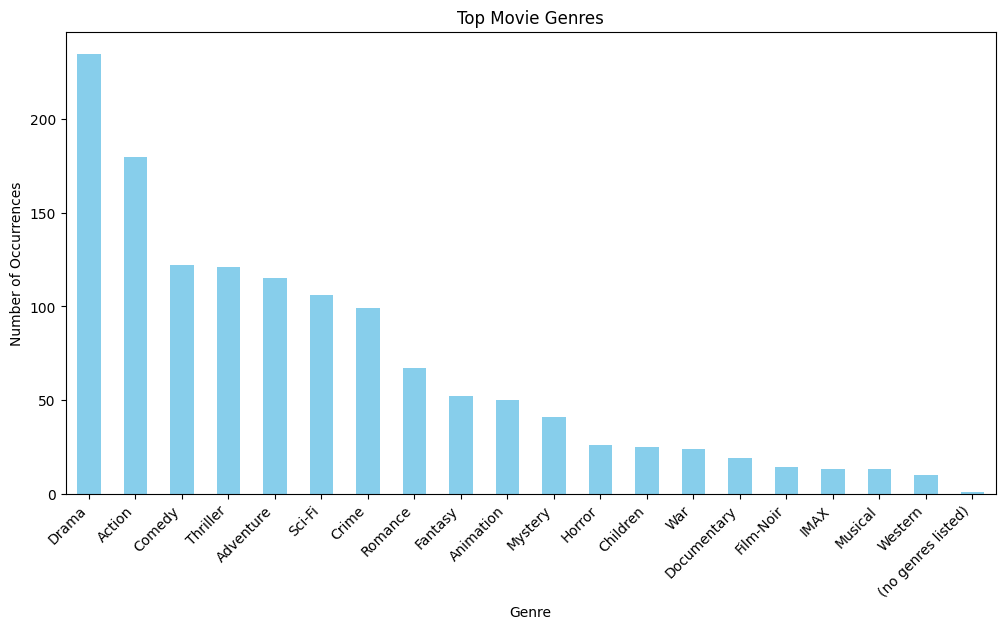

In [123]:
#let's show user's favourite genres to compare with our prediction
high_rated_movies = unique_movies[unique_movies['rating'].isin([4, 5])]#only the ones reviewed at list 4 by our user

genres = high_rated_movies['genres'].str.get_dummies('|')
# Calculate the number of occurrences of each genre
genre_counts = genres.sum()
# Sort genres by their occurrence in descending order
sorted_genres = genre_counts.sort_values(ascending=False)

plt.figure(figsize=(12, 6))
sorted_genres.plot(kind='bar', color='skyblue')
plt.title('Top Movie Genres')
plt.xlabel('Genre')
plt.ylabel('Number of Occurrences')
plt.xticks(rotation=45, ha='right')
plt.show()

In [132]:
#let's print our prediction
print("Recommended movie for user {}:".format(user_index))
print("'{}'".format(movies_df[movies_df.index == get_original_node(most_similar_movie)]['title'].values[0]))
print("It's genres are:")
print(movies_df[movies_df.index == get_original_node(most_similar_movie)]['genres'].values)

Recommended movie for user 599:
'Breaker Morant (1980)'
It's genres are:
['Drama|War']


In [108]:
movies_df.head(-20)

,title,genres
movieId,,
1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
2,Jumanji (1995),Adventure|Children|Fantasy
3,Grumpier Old Men (1995),Comedy|Romance
4,Waiting to Exhale (1995),Comedy|Drama|Romance
5,Father of the Bride Part II (1995),Comedy
...,...,...
188833,The Man Who Killed Don Quixote (2018),Adventure|Comedy|Fantasy
189043,Boundaries (2018),Comedy|Drama
189111,Spiral (2018),Documentary


In [107]:
ratings_df.head(-10)

,userId,movieId,rating,timestamp
0,1,1,4,964982703
1,1,1,4,964982703
2,1,1,4,964982703
3,1,1,4,964982703
4,1,3,4,964981247
...,...,...,...,...
368267,610,168248,5,1493850091
368268,610,168248,5,1493850091
368269,610,168250,5,1494273047
368270,610,168250,5,1494273047
